## CNN 1b

### Load Packages

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

#lokal imports
from dataset_generator import create_embedding_matrix, split_data, load_preprocess_data
from HumorDataset import TextDataset
from BalancedCELoss import BalancedCELoss
import ml_helper

### Datensatz laden und DatenLoader

In [77]:
torch.manual_seed(0)
np.random.seed(0)


best_model_filename = 'best_cnn_class_model.pt'
#device = ml_helper.get_device(verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### CNN-Modell definieren


In [78]:
# Hyperparameter und Konfigurationen
params = {
    "embedding_dim": 100,
    "filter_sizes": [2, 3, 4, 5],
    "num_filters": 150,
    "batch_size": 32,
    "learning_rate": 0.001,
    "epochs": 25,
    "glove_path": 'data/glove.6B.100d.txt',
    "max_len": 280,
    "test_size": 0.1,
    "val_size": 0.1,
    "patience": 5,
    "data_path": 'data/hack.csv',
    "dropout": 0.6,
    "weight_decay": 5e-4,
    "alpha": 0.1,  # Alpha für die Balance in der Loss-Funktion
    # patience for early stopping
    'early_stopping_patience': 5 # 5 (3 to 10)

}

In [79]:
class CNNBinaryClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters, embedding_matrix, dropout):
        super(CNNBinaryClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, num_filters, (fs, embedding_dim)),
                nn.BatchNorm2d(num_filters),
                nn.ReLU(),
                nn.MaxPool2d((params["max_len"] - fs + 1, 1)),
                nn.Dropout(dropout)
            )
            for fs in filter_sizes
        ])
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 Klassen, daher 2 Outputs für CrossEntropyLoss
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        conv_outputs = [conv(x).squeeze(3).squeeze(2) for conv in self.convs]
        x = torch.cat(conv_outputs, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # 2 Outputs, CrossEntropyLoss übernimmt die Softmax

In [80]:
# Daten laden
embedding_matrix, word_index, vocab_size, d_model = create_embedding_matrix(
    gloVe_path=params["glove_path"], emb_len=params["embedding_dim"]
)
X, y = load_preprocess_data(path_data=params["data_path"])


400002
vocab_size: 400002, d_model: 100


In [81]:

# Daten splitten
data_split = split_data(X, y, test_size=params["test_size"], val_size=params["val_size"])
train_dataset = TextDataset(data_split['train']['X'], data_split['train']['y'], word_index, max_len=params["max_len"])
val_dataset = TextDataset(data_split['val']['X'], data_split['val']['y'], word_index, max_len=params["max_len"])
test_dataset = TextDataset(data_split['test']['X'], data_split['test']['y'], word_index, max_len=params["max_len"])

train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)


train 3945 3945
test 494 494
val 493 493


In [82]:
import EarlyStopping as EarlyStopping
# Modell initialisieren
model = CNNBinaryClassifier(
    vocab_size=vocab_size,
    embedding_dim=params["embedding_dim"],
    filter_sizes=params["filter_sizes"],
    num_filters=params["num_filters"],
    embedding_matrix=embedding_matrix,
    dropout=params["dropout"]
)
model = model.to(device)

# BalancedCELoss verwenden
criterion = BalancedCELoss(alpha=params["alpha"])
optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
early_stopping = EarlyStopping.EarlyStopping(patience=params['early_stopping_patience'], verbose=False)

In [83]:
# Training
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(params["epochs"]):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{params['epochs']}") as pbar:
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            pbar.set_postfix({"Train Loss": loss.item()})

    train_acc = correct / total
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_acc"].append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_acc = correct / total
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/25: 100%|██████████| 124/124 [00:38<00:00,  3.26it/s, Train Loss=0.734]



Epoch 1, Train Loss: 105.9015, Val Loss: 12.5712
Train Accuracy: 0.4958, Val Accuracy: 0.5314


Epoch 2/25: 100%|██████████| 124/124 [00:36<00:00,  3.39it/s, Train Loss=0.79] 



Epoch 2, Train Loss: 91.0446, Val Loss: 12.5252
Train Accuracy: 0.5141, Val Accuracy: 0.5274


Epoch 3/25: 100%|██████████| 124/124 [00:36<00:00,  3.39it/s, Train Loss=0.826]



Epoch 3, Train Loss: 93.3248, Val Loss: 12.5840
Train Accuracy: 0.5039, Val Accuracy: 0.5254


Epoch 4/25: 100%|██████████| 124/124 [00:36<00:00,  3.40it/s, Train Loss=0.7]  



Epoch 4, Train Loss: 92.2199, Val Loss: 12.5006
Train Accuracy: 0.4984, Val Accuracy: 0.5517


Epoch 5/25: 100%|██████████| 124/124 [00:37<00:00,  3.29it/s, Train Loss=0.768]



Epoch 5, Train Loss: 91.2856, Val Loss: 11.9061
Train Accuracy: 0.5290, Val Accuracy: 0.5862


Epoch 6/25: 100%|██████████| 124/124 [00:40<00:00,  3.09it/s, Train Loss=0.694]



Epoch 6, Train Loss: 90.5596, Val Loss: 11.3011
Train Accuracy: 0.5430, Val Accuracy: 0.6126


Epoch 7/25: 100%|██████████| 124/124 [00:39<00:00,  3.18it/s, Train Loss=0.771]



Epoch 7, Train Loss: 89.5808, Val Loss: 11.5313
Train Accuracy: 0.5582, Val Accuracy: 0.6207


Epoch 8/25: 100%|██████████| 124/124 [00:36<00:00,  3.38it/s, Train Loss=0.697]



Epoch 8, Train Loss: 88.8963, Val Loss: 11.0529
Train Accuracy: 0.5648, Val Accuracy: 0.6308


Epoch 9/25: 100%|██████████| 124/124 [00:37<00:00,  3.34it/s, Train Loss=0.846]



Epoch 9, Train Loss: 88.4877, Val Loss: 11.0292
Train Accuracy: 0.5706, Val Accuracy: 0.6207


Epoch 10/25: 100%|██████████| 124/124 [00:36<00:00,  3.41it/s, Train Loss=0.756]



Epoch 10, Train Loss: 88.5556, Val Loss: 11.0032
Train Accuracy: 0.5833, Val Accuracy: 0.6308


Epoch 11/25: 100%|██████████| 124/124 [00:36<00:00,  3.41it/s, Train Loss=0.664]



Epoch 11, Train Loss: 88.3764, Val Loss: 10.7751
Train Accuracy: 0.5706, Val Accuracy: 0.6389


Epoch 12/25: 100%|██████████| 124/124 [00:38<00:00,  3.26it/s, Train Loss=0.866]



Epoch 12, Train Loss: 88.9168, Val Loss: 11.1027
Train Accuracy: 0.5721, Val Accuracy: 0.6085


Epoch 13/25: 100%|██████████| 124/124 [00:39<00:00,  3.13it/s, Train Loss=0.711]



Epoch 13, Train Loss: 88.4298, Val Loss: 11.0765
Train Accuracy: 0.5888, Val Accuracy: 0.6288


Epoch 14/25: 100%|██████████| 124/124 [00:39<00:00,  3.11it/s, Train Loss=0.728]



Epoch 14, Train Loss: 88.7229, Val Loss: 11.1684
Train Accuracy: 0.5823, Val Accuracy: 0.6349


Epoch 15/25: 100%|██████████| 124/124 [00:37<00:00,  3.28it/s, Train Loss=0.774]



Epoch 15, Train Loss: 89.3287, Val Loss: 11.4475
Train Accuracy: 0.5830, Val Accuracy: 0.6146


Epoch 16/25: 100%|██████████| 124/124 [00:35<00:00,  3.48it/s, Train Loss=0.797]



Epoch 16, Train Loss: 85.6701, Val Loss: 10.7575
Train Accuracy: 0.6175, Val Accuracy: 0.6329


Epoch 17/25: 100%|██████████| 124/124 [00:38<00:00,  3.23it/s, Train Loss=0.649]



Epoch 17, Train Loss: 83.7000, Val Loss: 10.7996
Train Accuracy: 0.6294, Val Accuracy: 0.6166


Epoch 18/25: 100%|██████████| 124/124 [00:37<00:00,  3.31it/s, Train Loss=0.703]



Epoch 18, Train Loss: 80.2727, Val Loss: 10.7781
Train Accuracy: 0.6679, Val Accuracy: 0.6450


Epoch 19/25: 100%|██████████| 124/124 [00:38<00:00,  3.24it/s, Train Loss=0.519]



Epoch 19, Train Loss: 73.5981, Val Loss: 11.1218
Train Accuracy: 0.7113, Val Accuracy: 0.6247


Epoch 20/25: 100%|██████████| 124/124 [00:36<00:00,  3.41it/s, Train Loss=1.05] 



Epoch 20, Train Loss: 66.4704, Val Loss: 11.3424
Train Accuracy: 0.7592, Val Accuracy: 0.6227


Epoch 21/25: 100%|██████████| 124/124 [00:25<00:00,  4.90it/s, Train Loss=0.794]



Epoch 21, Train Loss: 59.3716, Val Loss: 12.2167
Train Accuracy: 0.8043, Val Accuracy: 0.6024


Epoch 22/25: 100%|██████████| 124/124 [00:25<00:00,  4.79it/s, Train Loss=0.261]



Epoch 22, Train Loss: 48.0339, Val Loss: 13.4658
Train Accuracy: 0.8525, Val Accuracy: 0.6085


Epoch 23/25: 100%|██████████| 124/124 [00:23<00:00,  5.23it/s, Train Loss=0.218]



Epoch 23, Train Loss: 36.6165, Val Loss: 15.3780
Train Accuracy: 0.8966, Val Accuracy: 0.5963


Epoch 24/25: 100%|██████████| 124/124 [00:23<00:00,  5.29it/s, Train Loss=0.166] 



Epoch 24, Train Loss: 29.4375, Val Loss: 21.4867
Train Accuracy: 0.9202, Val Accuracy: 0.5822


Epoch 25/25: 100%|██████████| 124/124 [00:22<00:00,  5.40it/s, Train Loss=0.209] 



Epoch 25, Train Loss: 21.5571, Val Loss: 31.7498
Train Accuracy: 0.9437, Val Accuracy: 0.5578


In [84]:
# Testen und Visualisieren
model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        test_correct += (predicted == y_batch).sum().item()
        test_total += y_batch.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6235


🚀 Finale Test Accuracy: 0.6235
🚀 Finale Test F1 Score: 0.6189


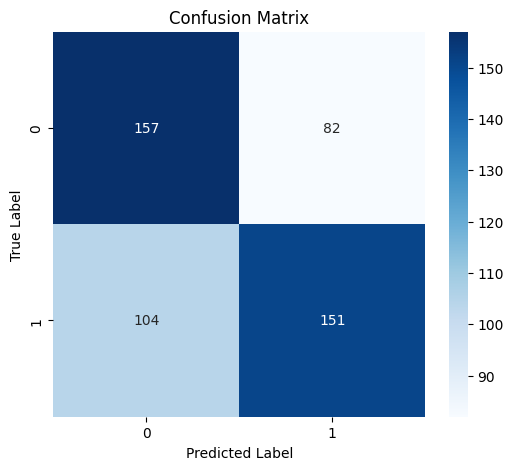

In [85]:
import ml_evaluation as ml_eval

print(f'🚀 Finale Test Accuracy: {ml_eval.get_accuracy(all_preds, all_labels):.4f}')
print(f'🚀 Finale Test F1 Score: {ml_eval.get_f1_score(all_preds, all_labels):.4f}')

# Confusion matrix
con_plt = ml_eval.plot_confusion_matrix(all_preds, all_labels, ['0', '1'])
con_plt.show()

In [86]:
ml_eval.get_label_distribution(all_labels, all_preds)

Class 0: 0.44
Class 1: 0.56


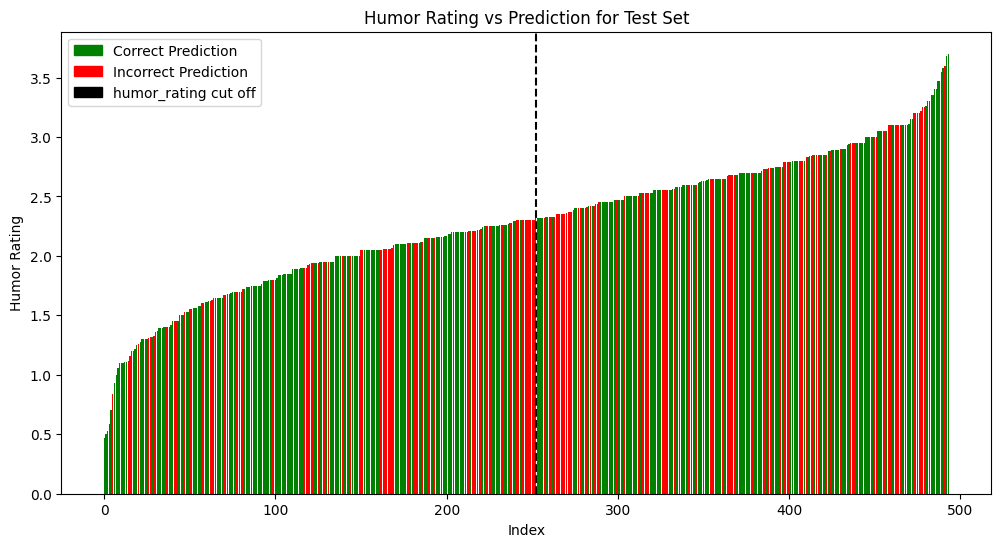

In [87]:
import ml_evaluation as ml_eval
ml_eval.plot_rating_preds(all_preds, all_labels, test_dataset).show()

In [88]:
def visualize_distribution(true_values, predicted_values):
    plt.figure(figsize=(10, 6))

    # Häufigkeiten der Klassen berechnen
    true_counts = np.bincount(true_values, minlength=2)
    predicted_counts = np.bincount(predicted_values, minlength=2)

    # Barplot erstellen
    labels = ['No Humor', 'Humor']
    x = np.arange(len(labels))

    plt.bar(x - 0.2, true_counts, width=0.4, color='skyblue', label='Wahre Werte', edgecolor='black')
    plt.bar(x + 0.2, predicted_counts, width=0.4, color='salmon', label='Vorhergesagte Werte', edgecolor='black')

    plt.title('Verteilung der wahren Werte und Vorhersagen')
    plt.xticks(x, labels)
    plt.ylabel('Häufigkeit')
    plt.xlabel('Klassen')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

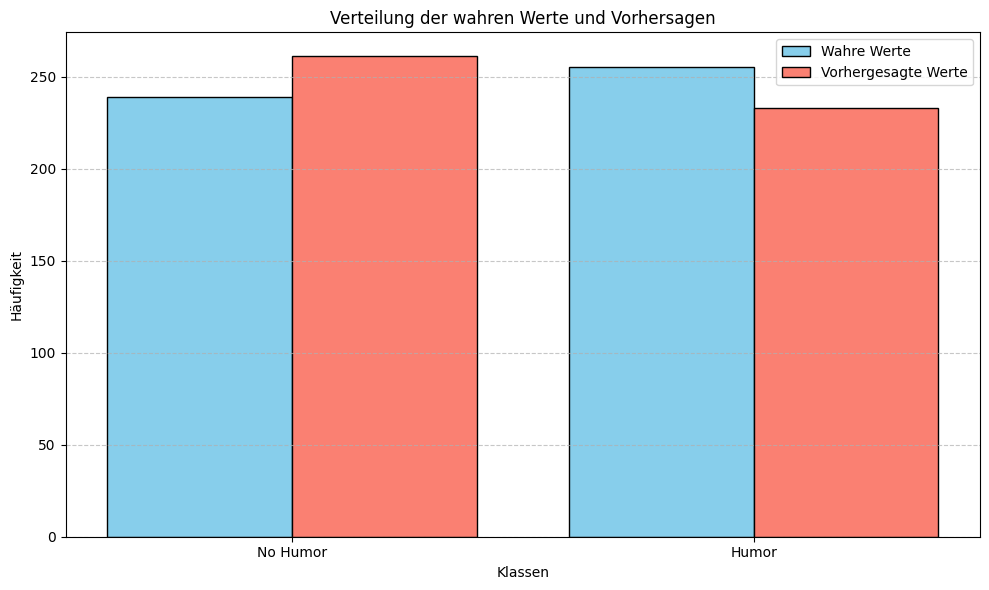

In [89]:
# Visualisierung der Verteilung (Barplot)
visualize_distribution(all_labels, all_preds)